In [0]:
import pandas as pd
energy = pd.read_csv('/content/drive/My Drive/data/energy.csv', parse_dates = ['timestamp'], index_col = 'timestamp')

In [0]:
val_start_dt = '2014-09-01 00:00:00'
test_start_dt = '2014-11-01 00:00:00'
energy.head()

,load,temp
timestamp,,
2012-01-01 00:00:00,2698.0,32.000000
2012-01-01 01:00:00,2558.0,32.666667
2012-01-01 02:00:00,2444.0,30.000000
2012-01-01 03:00:00,2402.0,31.000000
2012-01-01 04:00:00,2403.0,32.000000


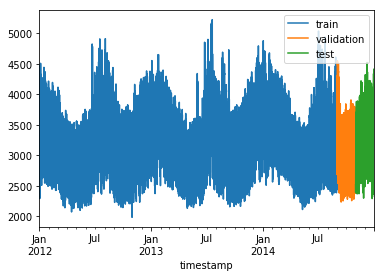

In [0]:
import numpy as np
energy[(energy.index < val_start_dt)][['load']].rename(columns={'load':'train'}).join(energy[(energy.index>=val_start_dt) & (energy.index<test_start_dt)][['load']].rename(columns={'load':'validation'}), how='outer')\
.join((energy[test_start_dt:][['load']]).rename(columns={'load':'test'}),how='outer').plot()

In [0]:
# t-5 t-4 t-3 t-2 t-1 t  :: t+1(horizon = 1)
#
t= 6
T = 6
HORIZON =1

In [0]:
# 1단계 트레인데이터 나누기
train = energy.copy()[energy.index < val_start_dt][['load']]

In [0]:
train.head()

,load
timestamp,
2012-01-01 00:00:00,2698.0
2012-01-01 01:00:00,2558.0
2012-01-01 02:00:00,2444.0
2012-01-01 03:00:00,2402.0
2012-01-01 04:00:00,2403.0


In [0]:
# 2단계 스케일링 할거임 0~1사이의 데이터로으로 만들거임 MinMaxScaler쓸거임
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head()


,load
timestamp,
2012-01-01 00:00:00,0.221572
2012-01-01 01:00:00,0.178428
2012-01-01 02:00:00,0.143297
2012-01-01 03:00:00,0.130354
2012-01-01 04:00:00,0.130663


In [0]:
# 3단계 t+1(y값)만들어줄거임 shift해서
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['load'].shift(-1, freq = 'h') # 원스텝모델만듬
train_shifted.head()
# 아리마모델할때 720시간 다 해줬는데 여기선 t-5 ~ t까지 다 만들어줘야함 t컬럼들을 보고 학습시켜야 하기떔에

,load,y_t+1
timestamp,,
2012-01-01 00:00:00,0.221572,0.178428
2012-01-01 01:00:00,0.178428,0.143297
2012-01-01 02:00:00,0.143297,0.130354
2012-01-01 03:00:00,0.130354,0.130663
2012-01-01 04:00:00,0.130663,0.146071


In [0]:

# 4단게 input sequence만들기
for t in range(1, T+1) :
  train_shifted[str(T-t)] = train_shifted['load'].shift(T-t, freq = 'h')

In [0]:
X_cols = ['load_t-5', 'load_t-4', 'load_t-3', 'load_t-2', 'load_t-1', 'load_t']
y_cols = 'y_t+1'

train_shifted.columns = ['original'] + [y_cols] + X_cols
train_shifted.head(10)

,original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
timestamp,,,,,,,,
2012-01-01 00:00:00,0.221572,0.178428,NaN,NaN,NaN,NaN,NaN,0.221572
2012-01-01 01:00:00,0.178428,0.143297,NaN,NaN,NaN,NaN,0.221572,0.178428
2012-01-01 02:00:00,0.143297,0.130354,NaN,NaN,NaN,0.221572,0.178428,0.143297
2012-01-01 03:00:00,0.130354,0.130663,NaN,NaN,0.221572,0.178428,0.143297,0.130354
2012-01-01 04:00:00,0.130663,0.146071,NaN,0.221572,0.178428,0.143297,0.130354,0.130663
2012-01-01 05:00:00,0.146071,0.179045,0.221572,0.178428,0.143297,0.130354,0.130663,0.146071
2012-01-01 06:00:00,0.179045,0.228043,0.178428,0.143297,0.130354,0.130663,0.146071,0.179045
2012-01-01 07:00:00,0.228043,0.288752,0.143297,0.130354,0.130663,0.146071,0.179045,0.228043
2012-01-01 08:00:00,0.288752,0.346995,0.130354,0.130663,0.146071,0.179045,0.228043,0.288752


In [0]:
# nan값지울게임 5시부터 예측하자
train_shifted = train_shifted.dropna(how = 'any')
train_shifted.head()

,original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
timestamp,,,,,,,,
2012-01-01 05:00:00,0.146071,0.179045,0.221572,0.178428,0.143297,0.130354,0.130663,0.146071
2012-01-01 06:00:00,0.179045,0.228043,0.178428,0.143297,0.130354,0.130663,0.146071,0.179045
2012-01-01 07:00:00,0.228043,0.288752,0.143297,0.130354,0.130663,0.146071,0.179045,0.228043
2012-01-01 08:00:00,0.288752,0.346995,0.130354,0.130663,0.146071,0.179045,0.228043,0.288752
2012-01-01 09:00:00,0.346995,0.368259,0.130663,0.146071,0.179045,0.228043,0.288752,0.346995


In [0]:
# 5단계 np.array배열로 (샘플, 피처)로 바꾸기/딥러닝에 넣으려면
# 우린 특성을 load하나봄 /샘플은 8 
# x_train을 만들자
X_train = train_shifted[X_cols].as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [0]:
X_train.shape # 특성은 하나지만 기억고있는특성은 t-5까지 봄

(23370, 6)

In [0]:
# ytrain도 만들자 특성이 1개가 나오겠지?
y_train = train_shifted[y_cols].as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [0]:
y_train.shape
# 딥러닝 모델에 데이터 프레임형태로 넣으면 안되니까 np.array형태로 as_metrix로 바꿨다.

(23370,)

In [0]:
import datetime as dt

In [0]:
# 6단계 validation데이터 세트 준비
look_back_dt = dt.datetime.strptime(val_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours = T-1) # 5시간 볼거니까 T = 6
valid = energy.copy()[(energy.index >= look_back_dt) & (energy.index < test_start_dt)][['load']] # validation도 예측해야하니까 train데이터에서 앞에 5개의 값을 가져옴/ 안그러면 valid 앞 5개는 nan이 쌓일거니까//look_back_dt는 val_start_dt(2014,9,1)에서 T-1 만큼 떙겨옴 train값을
valid.head()

,load
timestamp,
2014-08-31 19:00:00,3969.0
2014-08-31 20:00:00,3869.0
2014-08-31 21:00:00,3643.0
2014-08-31 22:00:00,3365.0
2014-08-31 23:00:00,3097.0


In [0]:
# validation data 스케일링
valid['load'] = scaler.transform(valid)
valid.head()

,load
timestamp,
2014-08-31 19:00:00,0.613251
2014-08-31 20:00:00,0.582435
2014-08-31 21:00:00,0.512789
2014-08-31 22:00:00,0.427119
2014-08-31 23:00:00,0.344530


In [0]:
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted['load'].shift(-1, freq='H')
valid_shifted.head()

,load,y+1
timestamp,,
2014-08-31 19:00:00,0.613251,0.582435
2014-08-31 20:00:00,0.582435,0.512789
2014-08-31 21:00:00,0.512789,0.427119
2014-08-31 22:00:00,0.427119,0.344530
2014-08-31 23:00:00,0.344530,0.279507


In [0]:
for t in range(1, T+1):
  valid_shifted['load_t-' + str(T-t)] = valid_shifted['load'].shift(T-t, freq='H')
valid_shifted.head()

,load,y+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
timestamp,,,,,,,,
2014-08-31 19:00:00,0.613251,0.582435,NaN,NaN,NaN,NaN,NaN,0.613251
2014-08-31 20:00:00,0.582435,0.512789,NaN,NaN,NaN,NaN,0.613251,0.582435
2014-08-31 21:00:00,0.512789,0.427119,NaN,NaN,NaN,0.613251,0.582435,0.512789
2014-08-31 22:00:00,0.427119,0.344530,NaN,NaN,0.613251,0.582435,0.512789,0.427119
2014-08-31 23:00:00,0.344530,0.279507,NaN,0.613251,0.582435,0.512789,0.427119,0.344530


In [0]:
valid_shifted = valid_shifted.dropna(how='any')

In [0]:
y_valid = valid_shifted['y+1'].as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [0]:
X_valid = valid_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [0]:
X_valid.shape

(1463, 6)

In [0]:
from keras.models import Model, Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [0]:
unit_dim = 5
bach_size = 32
epochs =50

In [0]:
model = Sequential()
model.add(Dense(unit_dim, activation='relu', input_shape=(T,)))
model.add(Dense(HORIZON))

W0726 04:15:57.997128 140633623644032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0726 04:15:58.017622 140633623644032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0726 04:15:58.020879 140633623644032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [0]:
model.compile(optimizer='RMSprop', loss = 'mse')

W0726 04:15:59.567367 140633623644032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 35        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [0]:
# early-stopping -> val data의 mse의 최저점을 찾으면 멈춰라/시간줄일수있음/패이션트=최저점을 찾고 몇번 더 내려가보고 안나오면 전에 찾은 최저점이 정답
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
earlystop = EarlyStopping(monitor = 'val_loss', patience = 5) # 뭘보고 얼리스탑핑하라고 할지 모니터 정해줌val_loss// 최저점 찾고도 혹시모르니 5번 더 가봐라

In [0]:
best_val = ModelCheckpoint('model_{epoch:02d}.h5', save_best_only = True, mode = 'min', period = 1) # 최저점이 어딘지 기억

In [0]:
history = model.fit(X_train, y_train, batch_size = bach_size, epochs = epochs, validation_data = (X_valid, y_valid), callbacks = [earlystop, best_val]) # 아마 earlystop하라는데까지만 에포크가 돌거임

W0726 04:16:07.515180 140633623644032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0726 04:16:07.522622 140633623644032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 23370 samples, validate on 1463 samples
Epoch 1/50
23370/23370 [==============================] - 3s 123us/step - loss: 0.0303 - val_loss: 0.0024
Epoch 2/50
23370/23370 [==============================] - 2s 65us/step - loss: 0.0023 - val_loss: 0.0019
Epoch 3/50
23370/23370 [==============================] - 2s 65us/step - loss: 0.0019 - val_loss: 0.0017
Epoch 4/50
23370/23370 [==============================] - 2s 64us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 5/50
23370/23370 [==============================] - 2s 65us/step - loss: 0.0015 - val_loss: 0.0014
Epoch 6/50
23370/23370 [==============================] - 1s 64us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 7/50
23370/23370 [==============================] - 2s 65us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 8/50
23370/23370 [==============================] - 2s 64us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/50
23370/23370 [==============================] - 2s 66us/step - loss: 0.0011 - val_loss: 9.7744e-04
E

In [0]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights("model_{:02d}.h5".format(best_epoch))

In [0]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'loss')

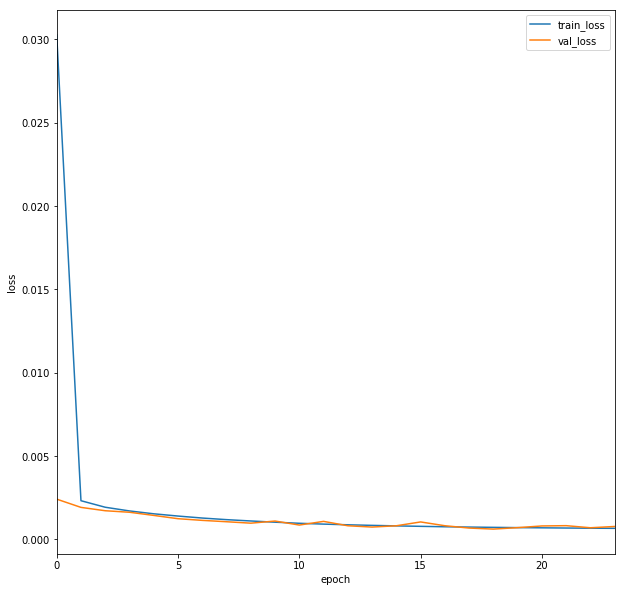

In [0]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(figsize = (10,10))
plt.xlabel('epoch')
plt.ylabel('loss')